In [61]:
!pip install scalecast --upgrade

In [62]:
!pip install scalecast

In [63]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.tsa.api as smt

from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from scalecast.Forecaster import Forecaster

from sklearn.linear_model import Lasso, SGDRegressor, Ridge, LinearRegression
from sklearn.ensemble import StackingRegressor, GradientBoostingRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
for dirname, _, filenames in os.walk('/content/drive/MyDrive/02.Hired/Bank_Stock_Price_10Y.csv'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [64]:
df = pd.read_csv('/content/drive/MyDrive/02.Hired/Bank_Stock_Price_10Y.csv')

In [65]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2483 entries, 0 to 2482
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       2483 non-null   object 
 1   Open       2483 non-null   float64
 2   High       2483 non-null   float64
 3   Low        2483 non-null   float64
 4   Close      2483 non-null   float64
 5   Adj Close  2483 non-null   float64
 6   Volume     2483 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 135.9+ KB


In [66]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-02-03,1980.0,2000.0,1965.0,1965.0,1691.382568,55407000
1,2014-02-04,1970.0,1980.0,1940.0,1970.0,1695.686035,83683500
2,2014-02-05,1980.0,1990.0,1965.0,1990.0,1712.901367,42715000
3,2014-02-06,1975.0,2030.0,1970.0,2030.0,1747.331299,63581000
4,2014-02-07,2050.0,2060.0,2035.0,2050.0,1764.546753,104825500


In [67]:
df.isna().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [68]:
df1 = df[['Date','Adj Close']].copy(deep=True)
df1['Date'] = pd.to_datetime(df1['Date'])
df1.set_index('Date',inplace = True)
df1.rename(columns={'Adj Close': 'Price'}, inplace=True)
df1 = df1.resample('W').mean()
df1.ffill(inplace=True)

In [69]:
df1[:10].style.background_gradient(cmap='viridis')

,Price
Date,
2014-02-09 00:00:00,1722.369604
2014-02-16 00:00:00,1760.242798
2014-02-23 00:00:00,1789.508545
2014-03-02 00:00:00,1775.736426
2014-03-09 00:00:00,1806.723584
2014-03-16 00:00:00,1814.470337
2014-03-23 00:00:00,1831.685498
2014-03-30 00:00:00,1786.926196
2014-04-06 00:00:00,1878.596679


In [70]:
df1.isna().sum()

Price    0
dtype: int64

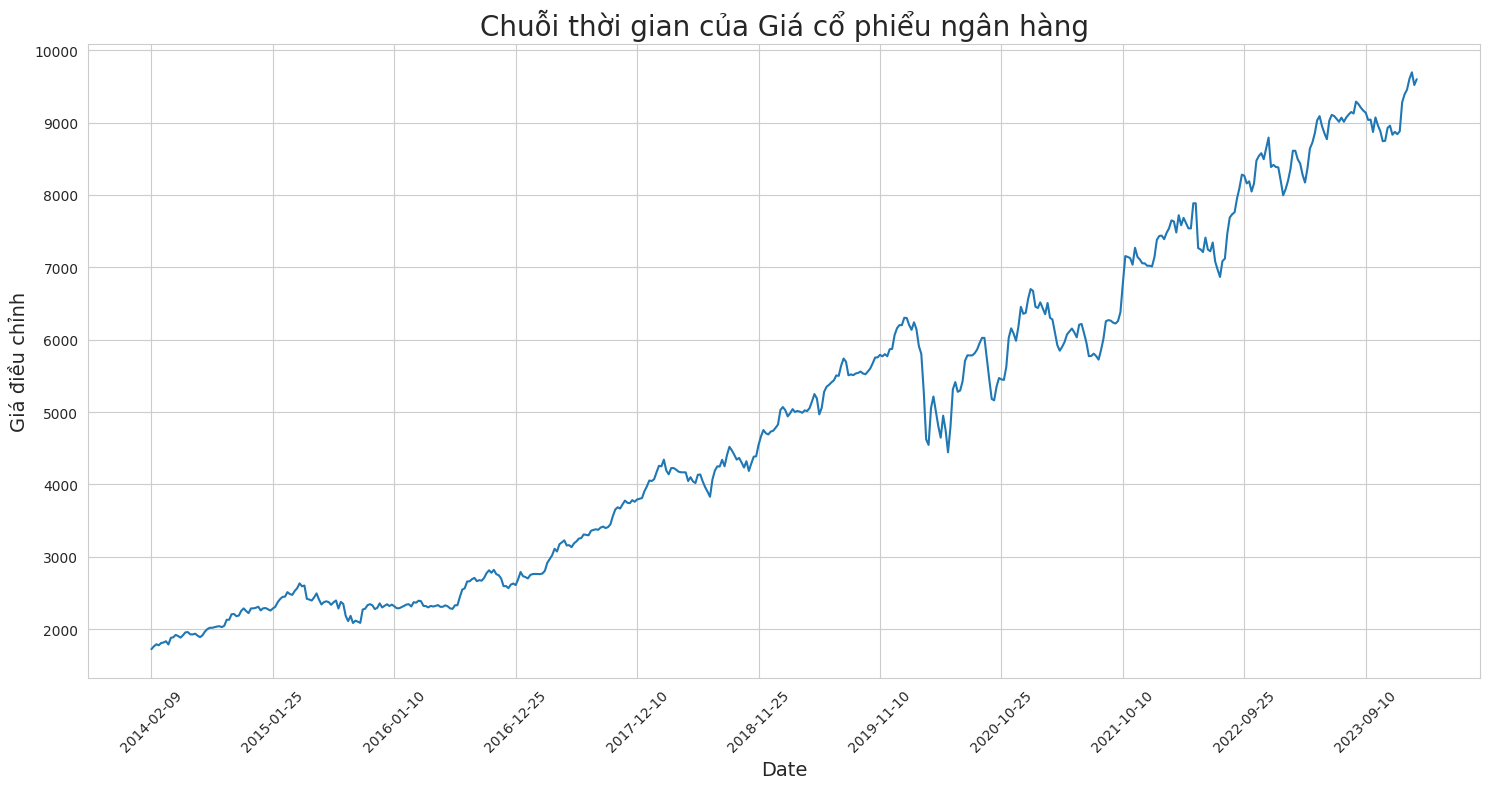

In [71]:
plt.figure(figsize=(15, 8))
sns.set_style("whitegrid")
ax=sns.lineplot(data=df1, x=df1.index, y='Price')

# Set x-axis ticks for every 50th data point
n = 50
plt.xticks(df1.index[::n])

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

plt.title("Chuỗi thời gian của Giá cổ phiểu ngân hàng", fontsize=20)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Giá điều chỉnh", fontsize=14)
plt.tight_layout()
plt.show()

In [72]:
def test_stationarity(timeseries):
    #Determing rolling statistics
    MA = timeseries.rolling(window=12).mean()
    MSTD = timeseries.rolling(window=12).std()

    #Plot rolling statistics:
    plt.figure(figsize=(15,8))
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(MA, color='red', label='Rolling Mean')
    std = plt.plot(MSTD, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [73]:
def tsplot(y, lags=None, figsize=(15, 8), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)

    with plt.style.context(style):
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))

        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

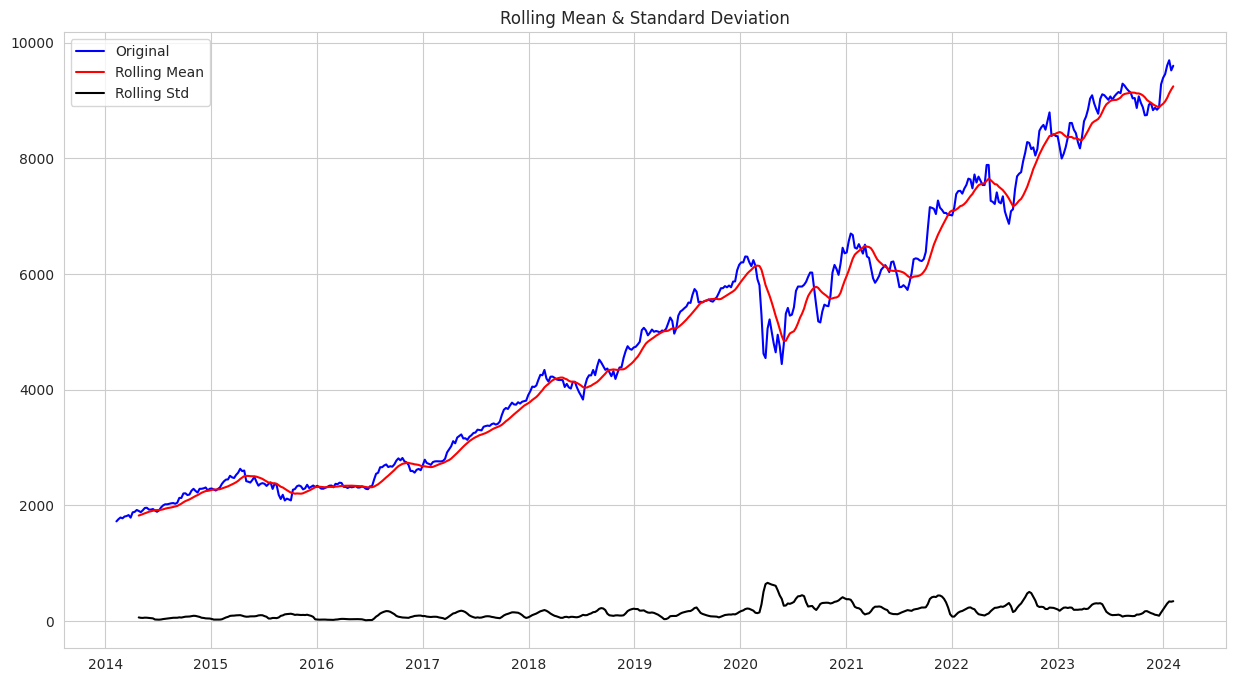

Results of Dickey-Fuller Test:
Test Statistic                   1.025763
p-value                          0.994530
#Lags Used                      17.000000
Number of Observations Used    504.000000
Critical Value (1%)             -3.443392
Critical Value (5%)             -2.867292
Critical Value (10%)            -2.569833
dtype: float64


In [74]:
test_stationarity(df1['Price'])

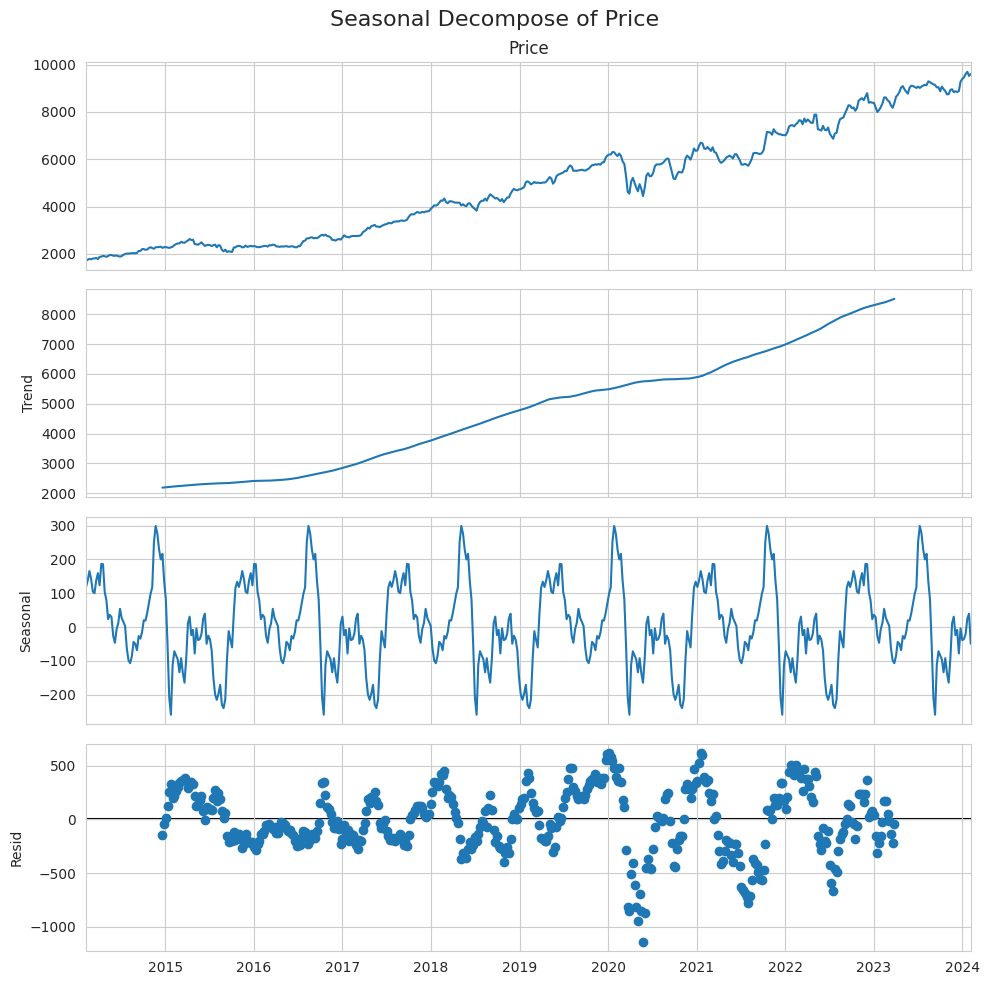

In [75]:
dec = sm.tsa.seasonal_decompose(df1['Price'], period=90).plot()

plt.suptitle('Seasonal Decompose of Price', fontsize=16)
plt.tight_layout()
plt.show()

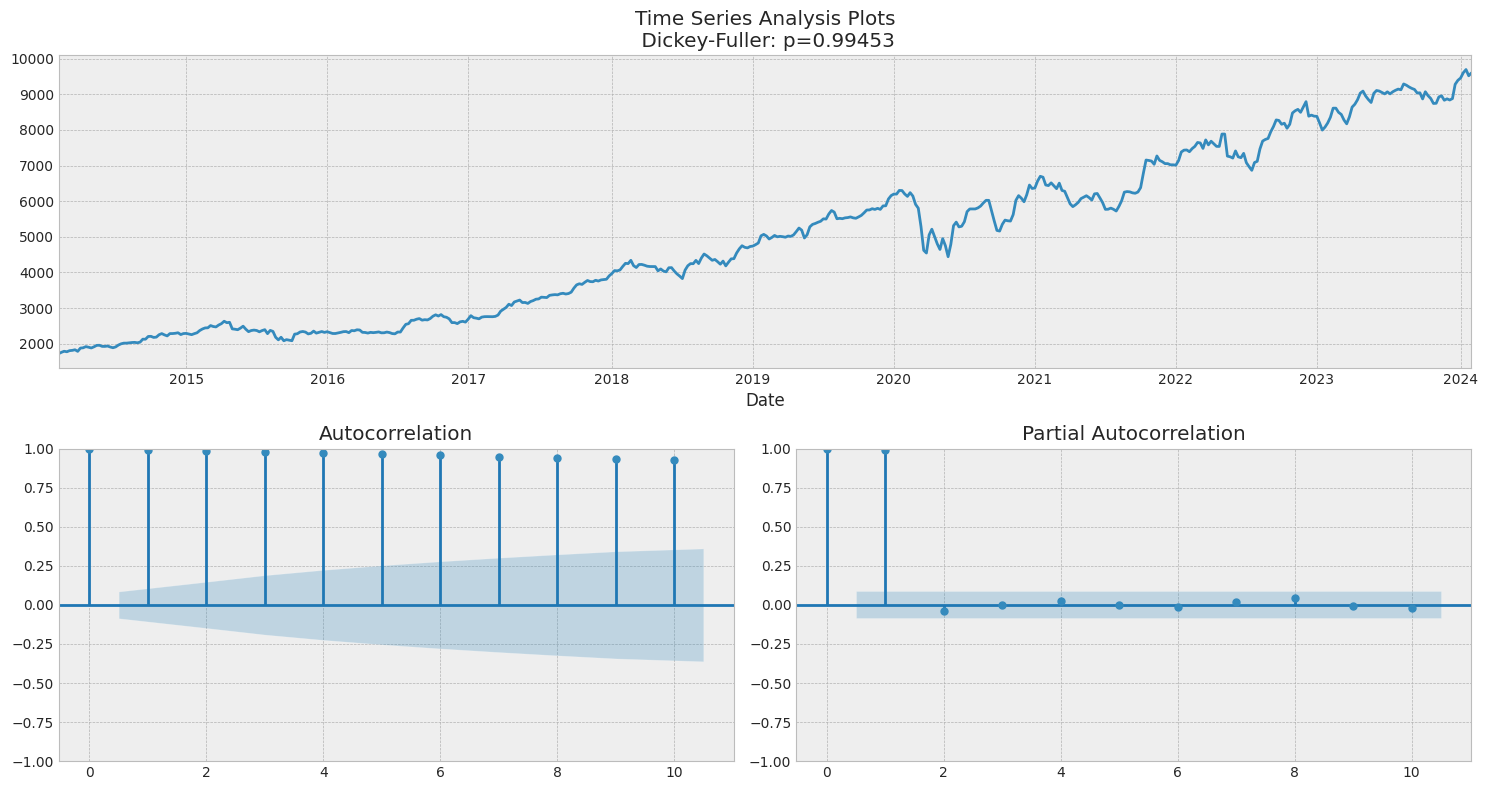

In [76]:
tsplot(df1['Price'], lags = 10)

In [77]:
df2 = df1.copy()
df2.head()

,Price
Date,
2014-02-09,1722.369604
2014-02-16,1760.242798
2014-02-23,1789.508545
2014-03-02,1775.736426
2014-03-09,1806.723584


In [78]:
# Take the first difference
df2['Price_Diff'] = df2['Price'].diff()
df2.head()

,Price,Price_Diff
Date,,
2014-02-09,1722.369604,NaN
2014-02-16,1760.242798,37.873194
2014-02-23,1789.508545,29.265747
2014-03-02,1775.736426,-13.772119
2014-03-09,1806.723584,30.987158


In [19]:
df2['Price_Log'] = np.log(df2['Price'])
df2.head()

,Price,Price_Diff,Price_Log
Date,,,
2014-02-09,1722.369604,NaN,7.451456
2014-02-16,1760.242798,37.873194,7.473207
2014-02-23,1789.508545,29.265747,7.489696
2014-03-02,1775.736426,-13.772119,7.481971
2014-03-09,1806.723584,30.987158,7.499270


In [20]:
df2['Price_Detrended'] = df2['Price'] - df2['Price'].rolling(window=30).mean()  # Adjust the window size as needed
df2.head()

,Price,Price_Diff,Price_Log,Price_Detrended
Date,,,,
2014-02-09,1722.369604,NaN,7.451456,NaN
2014-02-16,1760.242798,37.873194,7.473207,NaN
2014-02-23,1789.508545,29.265747,7.489696,NaN
2014-03-02,1775.736426,-13.772119,7.481971,NaN
2014-03-09,1806.723584,30.987158,7.499270,NaN


In [21]:
result_sd = seasonal_decompose(df2['Price'], model='additive', period=52)  # Assuming weekly seasonality, adjust period accordingly
df2['Price_Seasonal_Adjusted'] = df2['Price'] - result_sd.seasonal
df2.head()

,Price,Price_Diff,Price_Log,Price_Detrended,Price_Seasonal_Adjusted
Date,,,,,
2014-02-09,1722.369604,NaN,7.451456,NaN,1556.145346
2014-02-16,1760.242798,37.873194,7.473207,NaN,1592.903733
2014-02-23,1789.508545,29.265747,7.489696,NaN,1585.888096
2014-03-02,1775.736426,-13.772119,7.481971,NaN,1588.273249
2014-03-09,1806.723584,30.987158,7.499270,NaN,1667.476890


In [22]:
window_size = 30  # Adjust the window size as needed
df2['Price_Rolling_Mean'] = df2['Price'].rolling(window=window_size).mean()
df2['Price_Rolling_Std'] = df2['Price'].rolling(window=window_size).std()
df2.head()

,Price,Price_Diff,Price_Log,Price_Detrended,Price_Seasonal_Adjusted,Price_Rolling_Mean,Price_Rolling_Std
Date,,,,,,,
2014-02-09,1722.369604,NaN,7.451456,NaN,1556.145346,NaN,NaN
2014-02-16,1760.242798,37.873194,7.473207,NaN,1592.903733,NaN,NaN
2014-02-23,1789.508545,29.265747,7.489696,NaN,1585.888096,NaN,NaN
2014-03-02,1775.736426,-13.772119,7.481971,NaN,1588.273249,NaN,NaN
2014-03-09,1806.723584,30.987158,7.499270,NaN,1667.476890,NaN,NaN


In [23]:
df2.isna().sum()

Price                       0
Price_Diff                  1
Price_Log                   0
Price_Detrended            29
Price_Seasonal_Adjusted     0
Price_Rolling_Mean         29
Price_Rolling_Std          29
dtype: int64

In [24]:
df2.dropna(inplace=True)
df2.head()

,Price,Price_Diff,Price_Log,Price_Detrended,Price_Seasonal_Adjusted,Price_Rolling_Mean,Price_Rolling_Std
Date,,,,,,,
2014-08-31,2027.125952,-12.133350,7.614374,120.207970,2061.815317,1906.917983,89.598752
2014-09-07,2045.325879,18.199927,7.623312,127.642687,2059.693306,1917.683192,85.989596
2014-09-14,2128.525391,83.199511,7.663185,198.566112,2144.001888,1929.959278,88.974617
2014-09-21,2127.659033,-0.866357,7.662778,186.428072,2176.568680,1941.230961,91.937995
2014-09-28,2204.792041,77.133008,7.698388,249.259226,2274.751163,1955.532815,98.447424


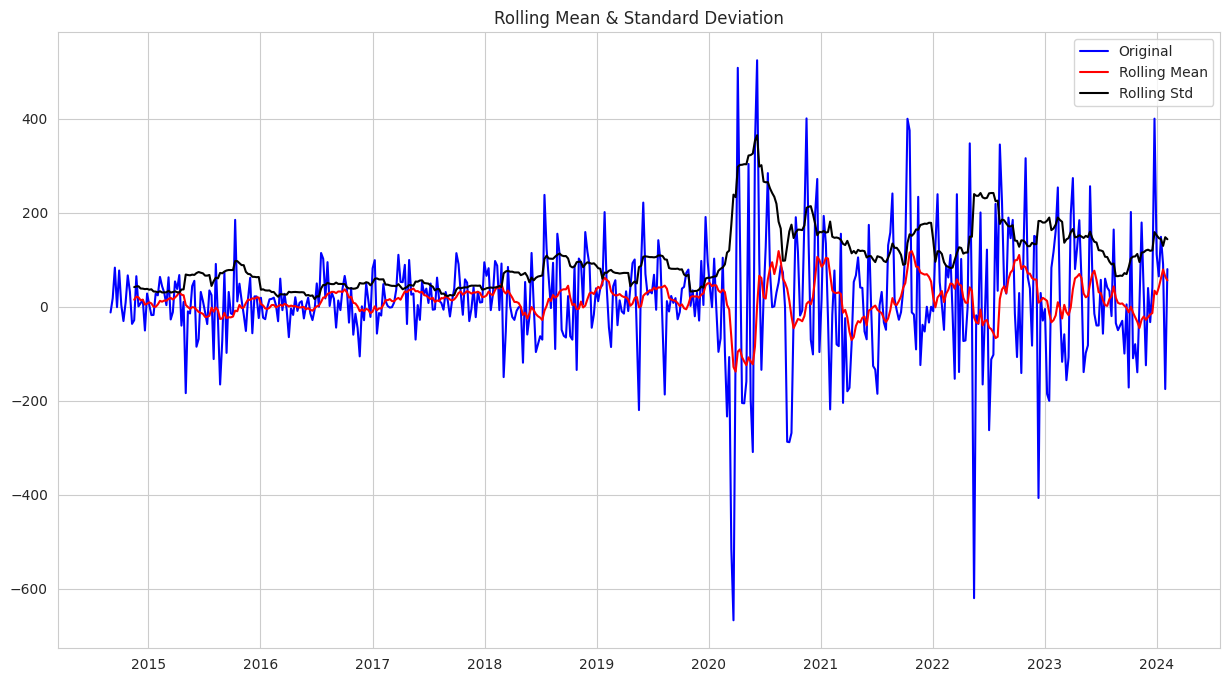

Results of Dickey-Fuller Test:
Test Statistic                -7.753459e+00
p-value                        9.878975e-12
#Lags Used                     1.600000e+01
Number of Observations Used    4.760000e+02
Critical Value (1%)           -3.444163e+00
Critical Value (5%)           -2.867631e+00
Critical Value (10%)          -2.570014e+00
dtype: float64


In [25]:
test_stationarity(df2['Price_Diff'])

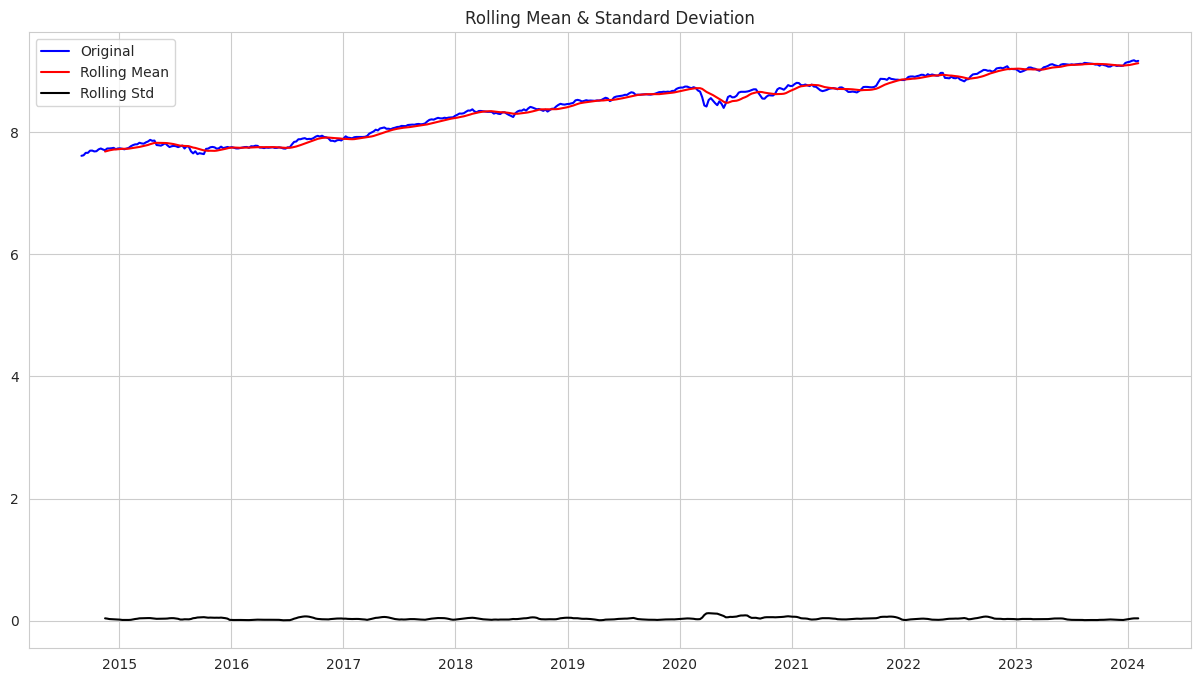

Results of Dickey-Fuller Test:
Test Statistic                  -0.616359
p-value                          0.867243
#Lags Used                       2.000000
Number of Observations Used    490.000000
Critical Value (1%)             -3.443766
Critical Value (5%)             -2.867457
Critical Value (10%)            -2.569921
dtype: float64


In [26]:
test_stationarity(df2['Price_Log'])

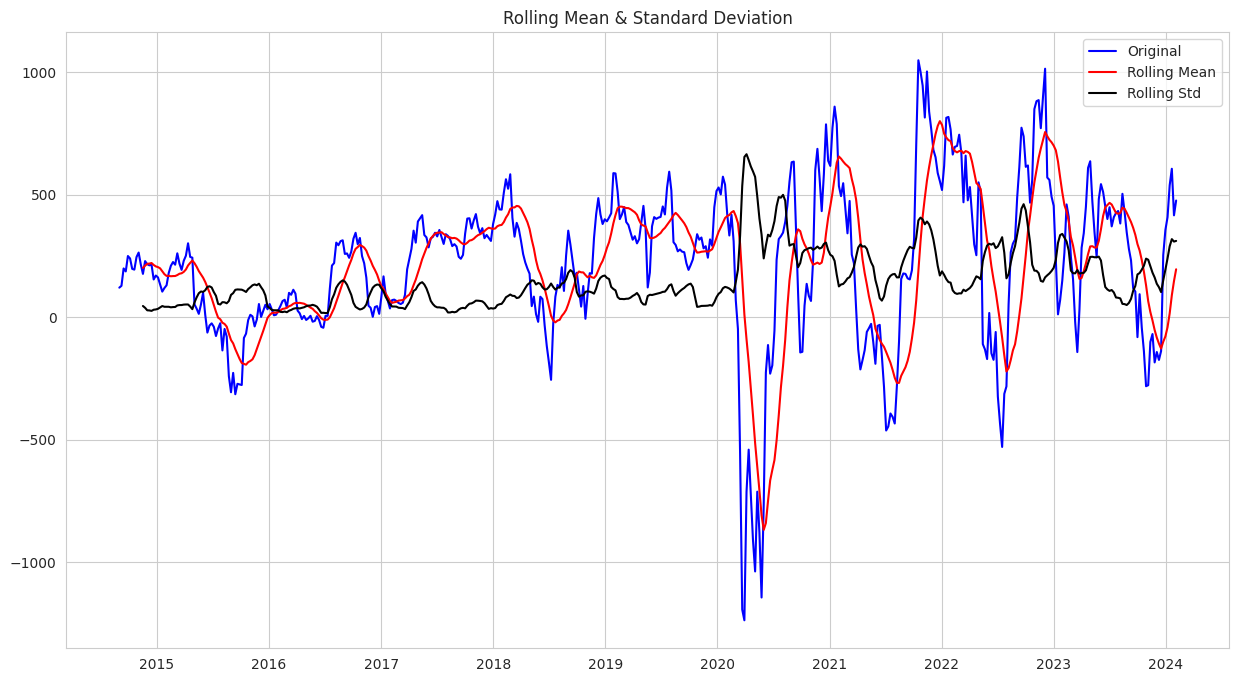

Results of Dickey-Fuller Test:
Test Statistic                -6.140943e+00
p-value                        7.974300e-08
#Lags Used                     9.000000e+00
Number of Observations Used    4.830000e+02
Critical Value (1%)           -3.443962e+00
Critical Value (5%)           -2.867543e+00
Critical Value (10%)          -2.569967e+00
dtype: float64


In [27]:
test_stationarity(df2['Price_Detrended'])

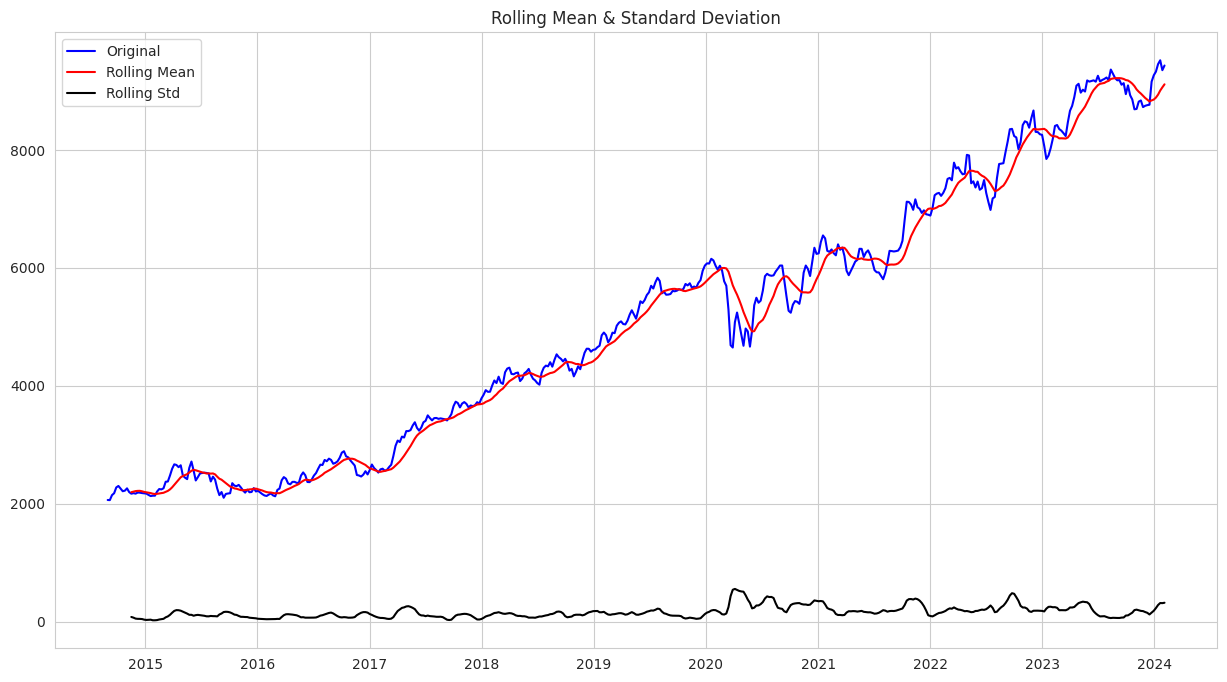

Results of Dickey-Fuller Test:
Test Statistic                   0.978618
p-value                          0.994035
#Lags Used                      17.000000
Number of Observations Used    475.000000
Critical Value (1%)             -3.444192
Critical Value (5%)             -2.867644
Critical Value (10%)            -2.570021
dtype: float64


In [28]:
test_stationarity(df2['Price_Seasonal_Adjusted'])

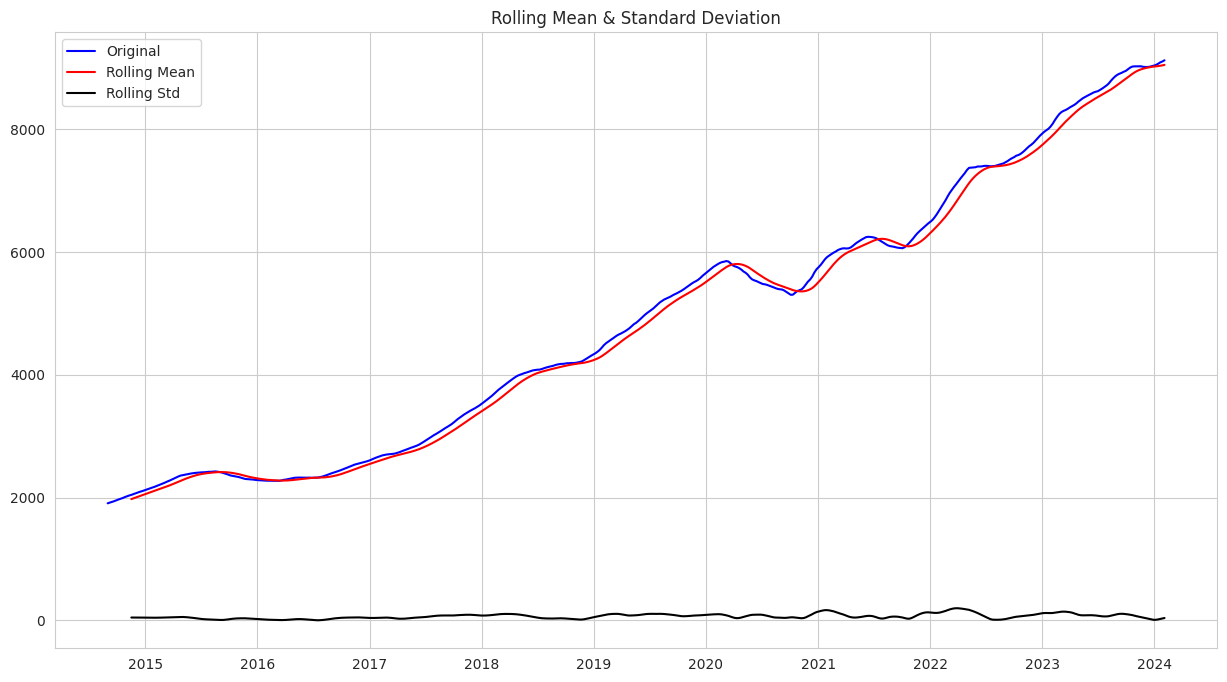

Results of Dickey-Fuller Test:
Test Statistic                   1.455138
p-value                          0.997351
#Lags Used                      14.000000
Number of Observations Used    478.000000
Critical Value (1%)             -3.444105
Critical Value (5%)             -2.867606
Critical Value (10%)            -2.570001
dtype: float64


In [29]:
test_stationarity(df2['Price_Rolling_Mean'])

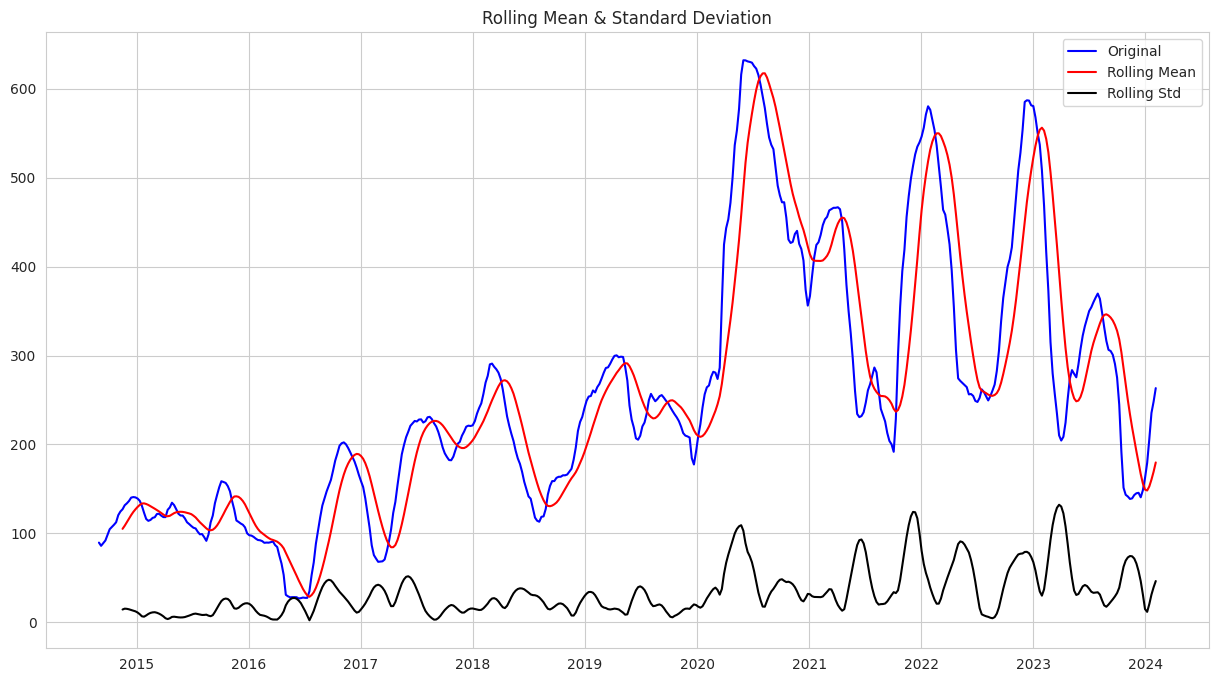

Results of Dickey-Fuller Test:
Test Statistic                  -3.672612
p-value                          0.004515
#Lags Used                       3.000000
Number of Observations Used    489.000000
Critical Value (1%)             -3.443794
Critical Value (5%)             -2.867469
Critical Value (10%)            -2.569928
dtype: float64


In [30]:
test_stationarity(df2['Price_Rolling_Std'])

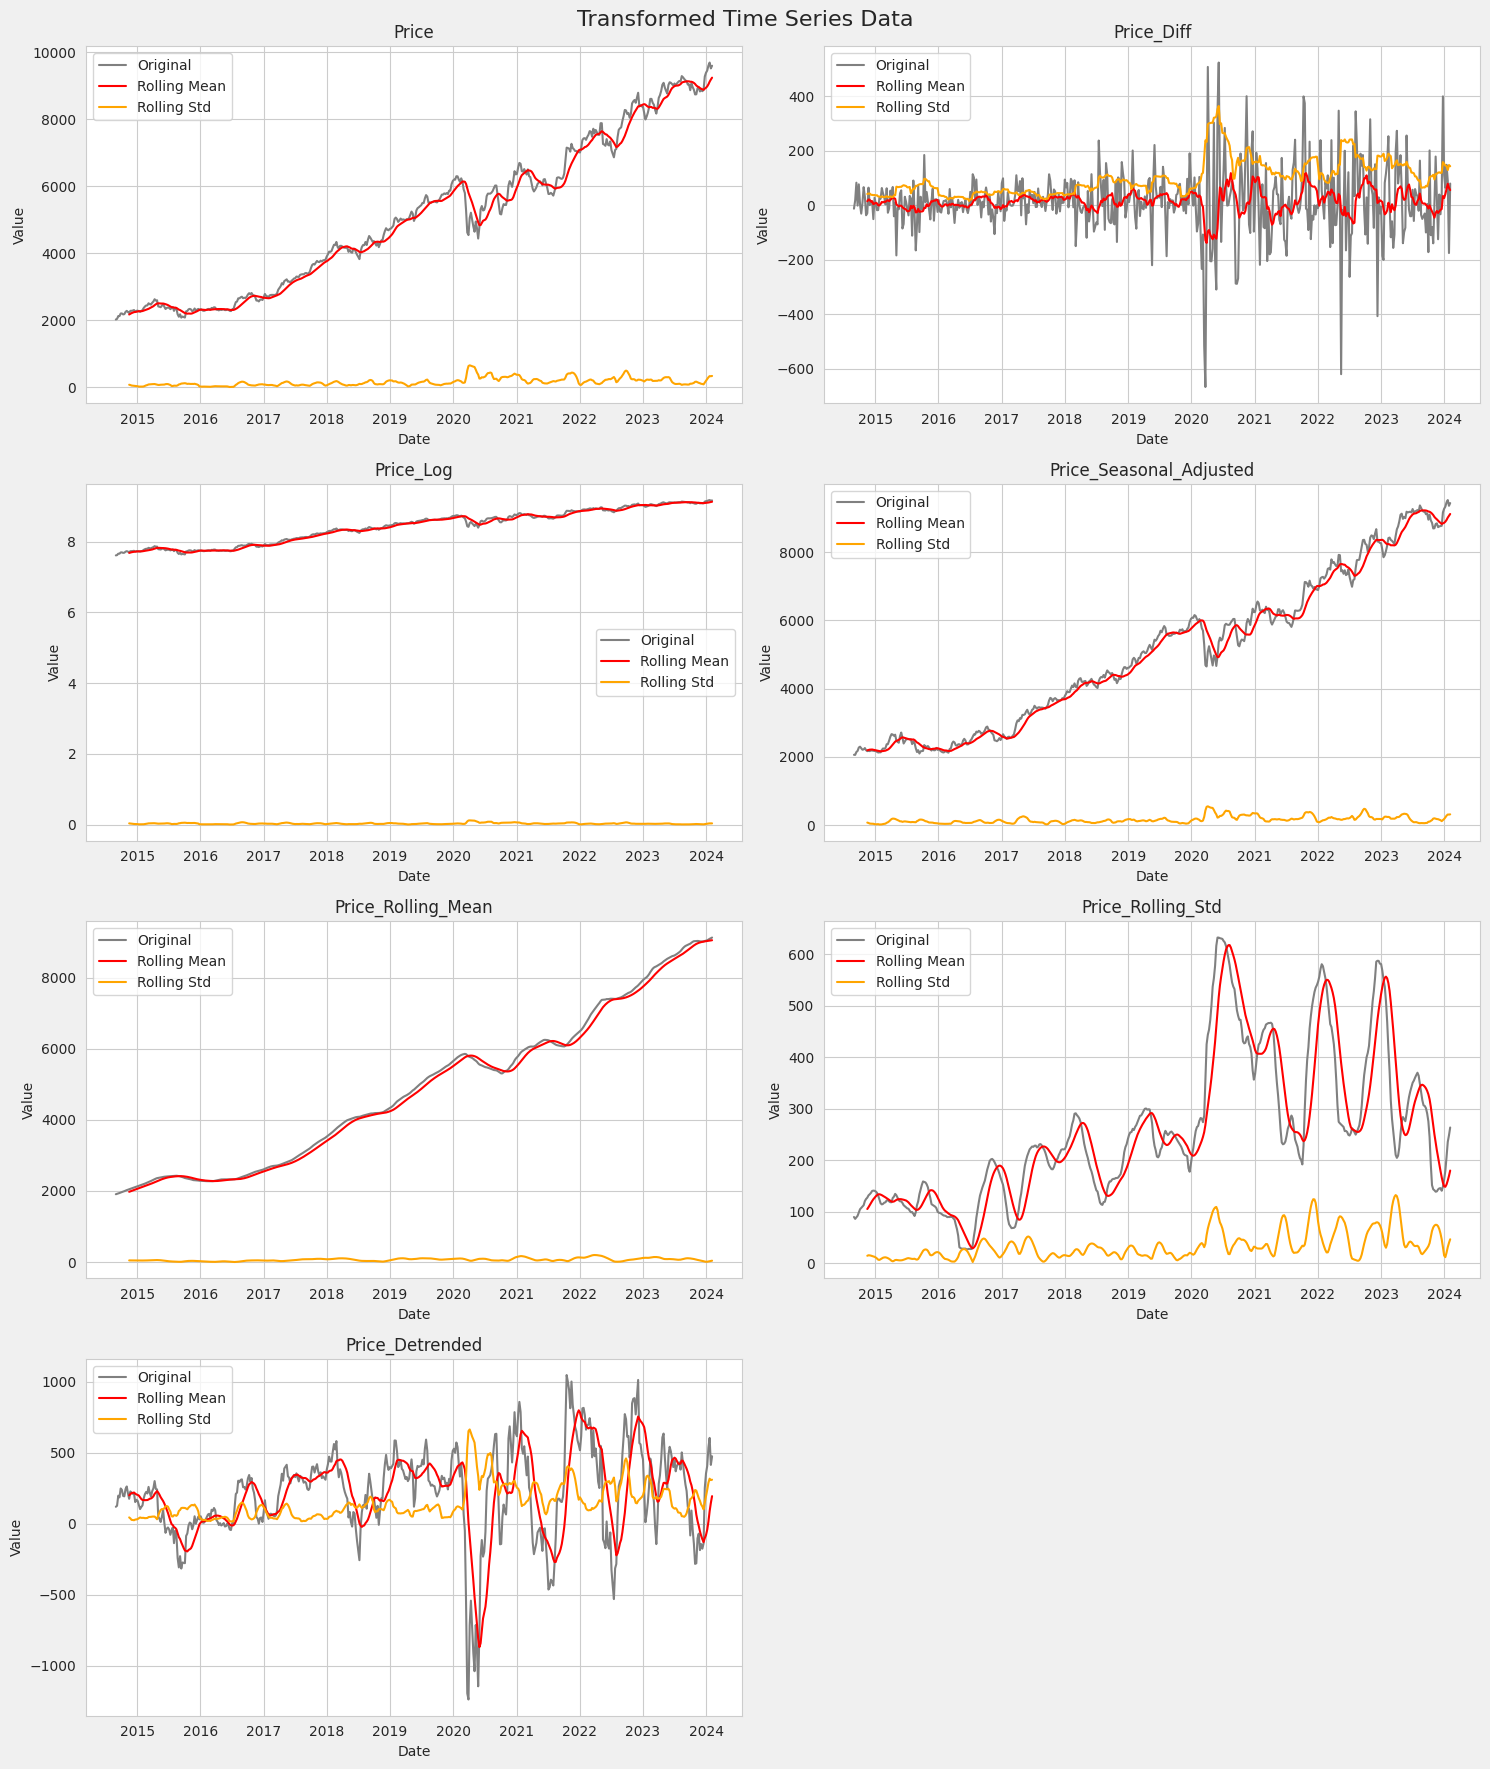

In [31]:
fig, axes = plt.subplots(4, 2, figsize=(15, 18), facecolor='#f0f0f0')

# Flatten the axes
axes = axes.flatten()

# List of columns to plot
columns_to_plot = ['Price', 'Price_Diff', 'Price_Log', 'Price_Seasonal_Adjusted', 'Price_Rolling_Mean', 'Price_Rolling_Std', 'Price_Detrended']

# Plot each column
for i, col in enumerate(columns_to_plot):
    ax = axes[i]
    ax.plot(df2.index, df2[col], label='Original', color='grey')

    # Calculate rolling statistics
    MA = df2[col].rolling(window=12).mean()
    MSTD = df2[col].rolling(window=12).std()

    ax.plot(df2.index, MA, color='red', label='Rolling Mean')
    ax.plot(df2.index, MSTD, color='orange', label='Rolling Std')

    ax.set_title(col)
    ax.set_xlabel('Date')
    ax.set_ylabel('Value')
    ax.legend()

# Hide any unused subplots
for i in range(len(columns_to_plot), 4 * 2):
    fig.delaxes(axes[i])

plt.suptitle("Transformed Time Series Data", size=16)
plt.tight_layout()
plt.show()

In [32]:
Price = df2.Price_Detrended  # Adjust the chosen column as needed
Dates = df2.index

In [33]:
f = Forecaster(y=Price, current_dates=Dates)

f.set_test_length(0.25)
f.generate_future_dates(90)

In [34]:
f

Forecaster(
    DateStartActuals=2014-08-31T00:00:00.000000000
    DateEndActuals=2024-02-04T00:00:00.000000000
    Freq=W-SUN
    N_actuals=493
    ForecastLength=90
    Xvars=[]
    TestLength=123
    ValidationMetric=rmse
    ForecastsEvaluated=[]
    CILevel=None
    CurrentEstimator=mlr
    GridsFile=Grids
)

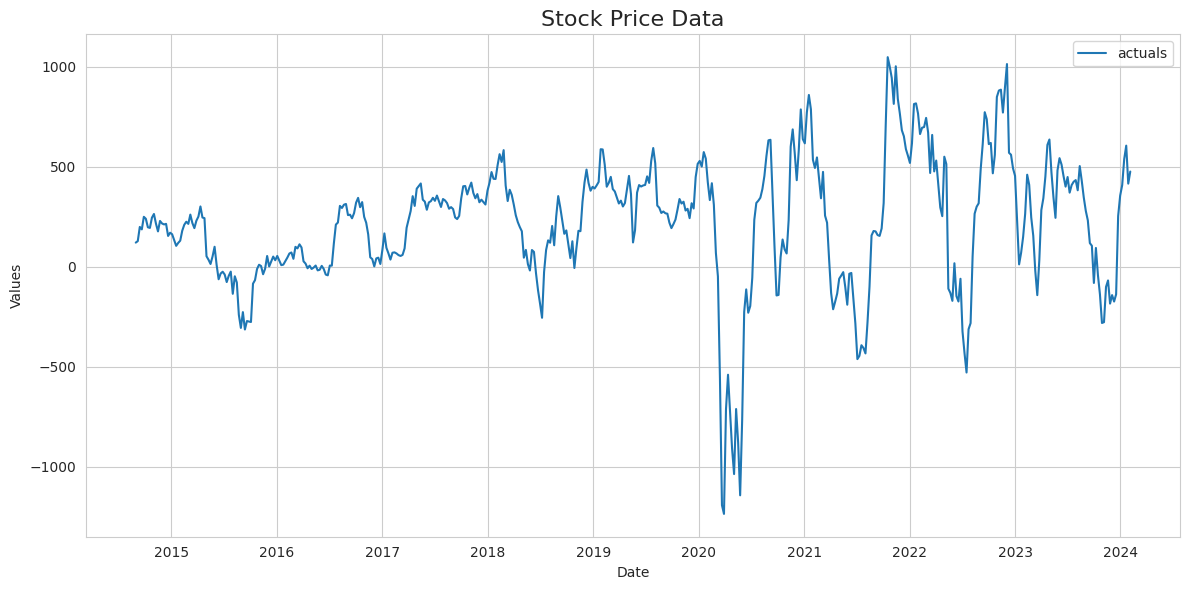

In [35]:
f.plot()
plt.title('Stock Price Data', size=16)
plt.tight_layout()
plt.show()

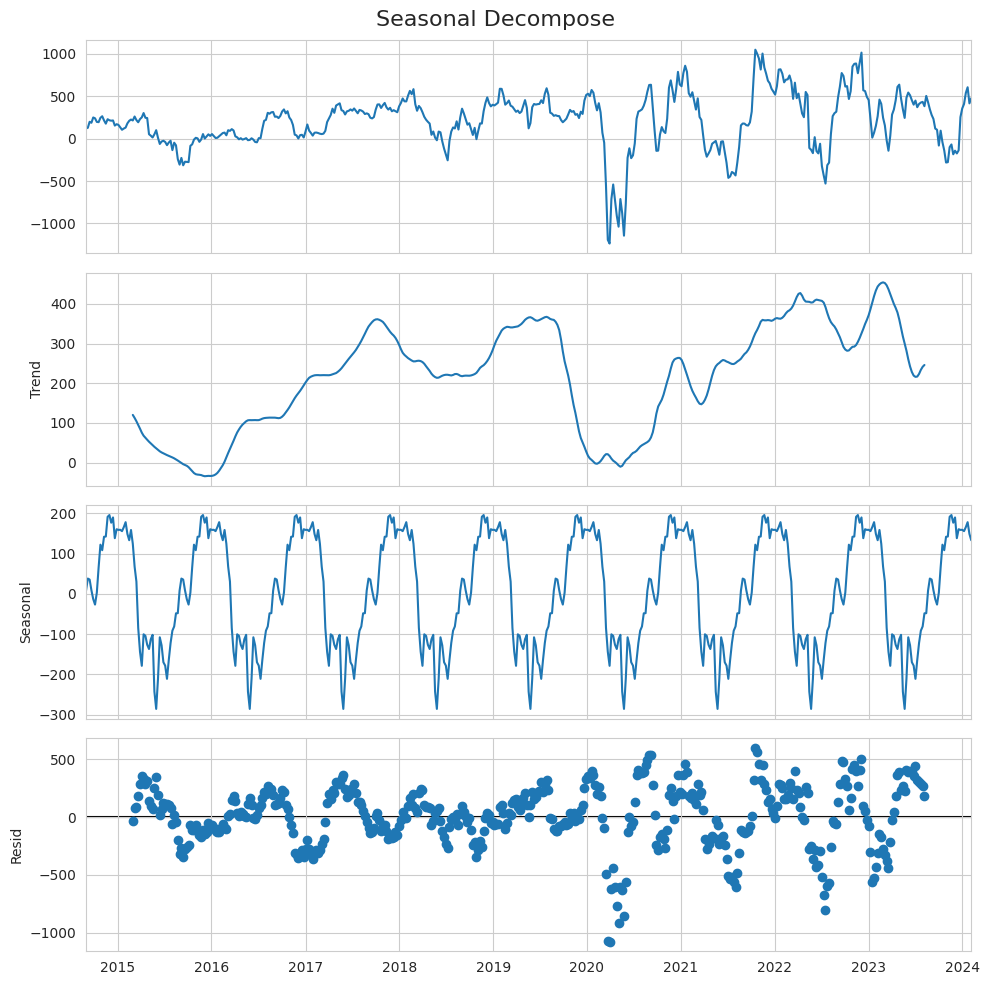

In [36]:
plt.rc("figure", figsize=(10,10))
f.seasonal_decompose().plot()
plt.suptitle('Seasonal Decompose', fontsize=16)
plt.tight_layout()
plt.show()

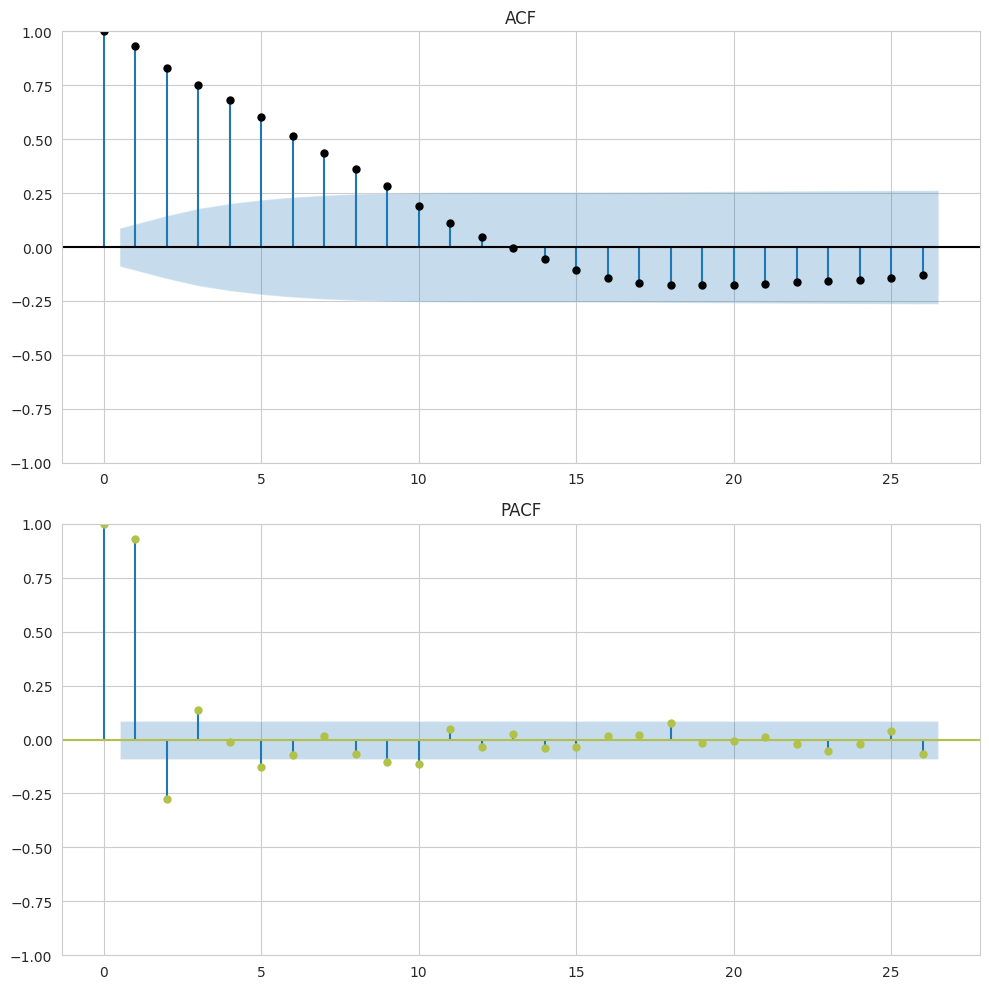

In [37]:
figs, axs = plt.subplots(2, 1, figsize=(10,10))
f.plot_acf(ax=axs[0], title='ACF', lags=26, color='black')
f.plot_pacf(ax=axs[1], title='PACF', lags=26, color='#B2C248', method='ywm')
plt.tight_layout()
plt.show()

1/1 [==============================] - 1s 1s/step


Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.


12/12 [==============================] - 1s 40ms/step


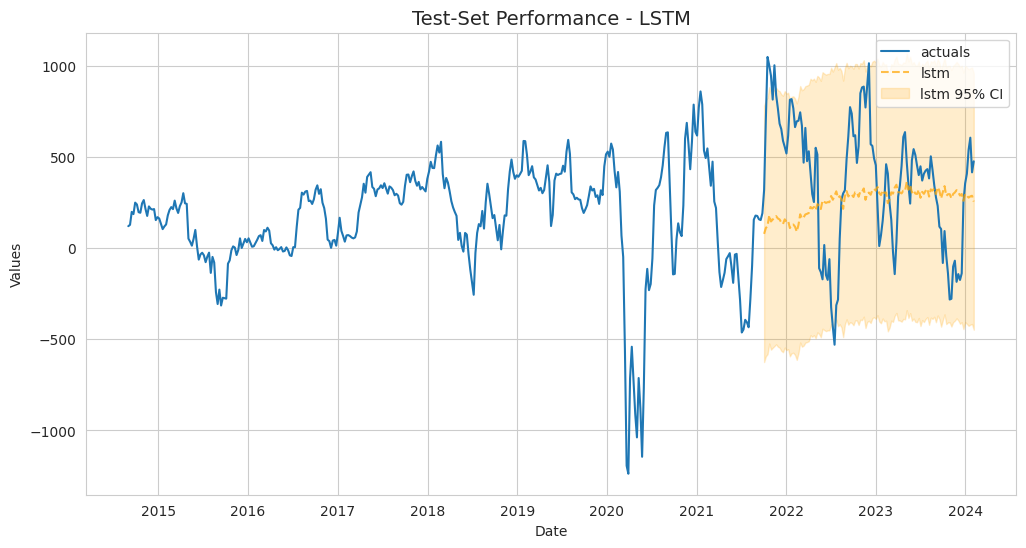

In [38]:
f.add_seasonal_regressors('week', raw=False, sincos=True)
f.set_estimator('lstm')
f.eval_cis(mode=True, cilevel=0.95)
f.manual_forecast(
    lags=36,
    batch_size=32,
    epochs=15,
    validation_split=.2,
    activation='tanh',
    optimizer='Adam',
    learning_rate=0.001,
    lstm_layer_sizes=(100,)*3,
    dropout=(0,)*3,
    verbose=False
)

f.plot_test_set(models='lstm', ci=True)
plt.title('Test-Set Performance - LSTM', size=14)
plt.show()

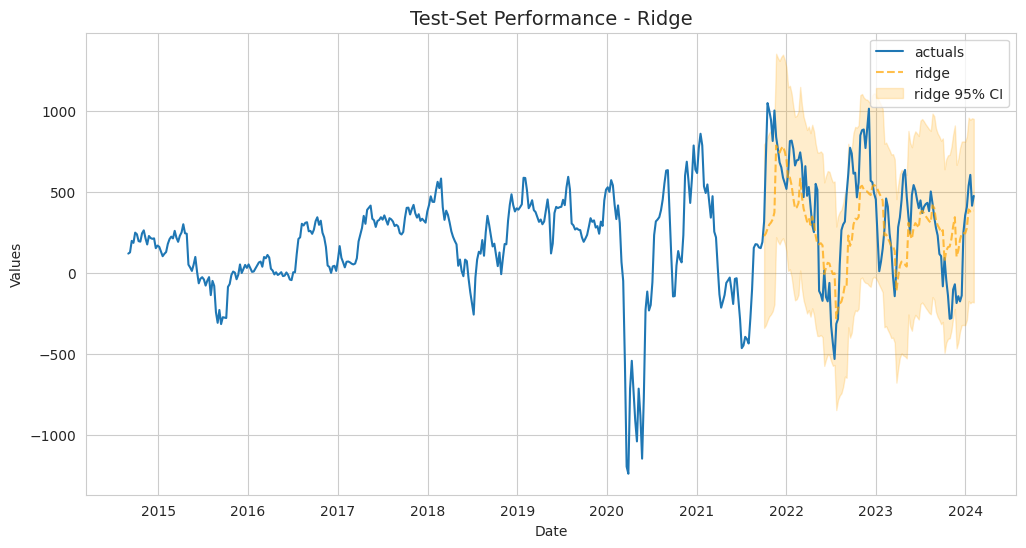

In [39]:
f.set_estimator('ridge')
f.add_ar_terms(7)
f.add_seasonal_regressors('month', 'quarter', dummy=True)
f.add_time_trend()
f.eval_cis(mode=True, cilevel=0.95)

f.manual_forecast(call_me='ridge', dynamic_testing=7)
f.plot_test_set(models='ridge', ci=True)
plt.title('Test-Set Performance - Ridge', size=14)
plt.show()

In [55]:
results = f.export(dfs=['model_summaries','lvl_fcsts'], cis=True, to_excel=True)
model_summaries = results['model_summaries']
lvl_fcsts = results['lvl_fcsts']
ts_preds = f.export('lvl_test_set_predictions')
model_eval = model_summaries[['ModelNickname','TestSetMAPE','TestSetRMSE','TestSetR2']].copy()
model_eval['Rank'] = model_eval['TestSetRMSE'].rank(ascending=True).astype(int)
model_eval.style.background_gradient(cmap='crest')

,ModelNickname,TestSetMAPE,TestSetRMSE,TestSetR2,Rank
0,lstm,1.579827,402.366025,-0.302624,2
1,ridge,1.298929,299.678614,0.277417,1


In [56]:
model_eval = model_eval.sort_values(by='Rank')
model_eval.style.background_gradient(cmap='viridis')

,ModelNickname,TestSetMAPE,TestSetRMSE,TestSetR2,Rank
1,ridge,1.298929,299.678614,0.277417,1
0,lstm,1.579827,402.366025,-0.302624,2
